# pyroomacustics 테스트
- Room Impulse Respose Generation

In [1]:
'''
# 라이브러리 정의
 - 시스템 라이브러리
 - 오디오 관련 라이브러리
 - 연산 및 Plot 관련 라이브러리 
 - 샤용자 라이브러리
'''

# Import Systems 
import struct
import io
import os
import sys
import math
import platform

# Import Audio
import pyaudio
import librosa
import soundfile
import pyroomacoustics as pyroom

import numpy as np
#from scipy.io import wavfile
import scipy.signal as sig
import matplotlib.pyplot as plt

#import GUI
import tkinter as tk
from tkinter import filedialog

# User Libraries
import pyOssWavfile
import pyRoomAcoustic as room
import pyOssDebug as dbg
import pyOssFilter


0.10331698666533118 162


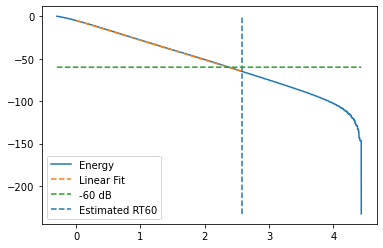

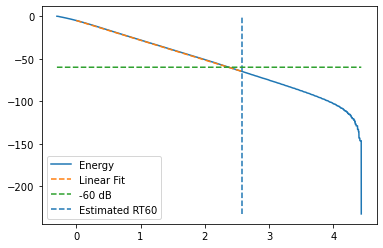

The desired RT60 was 1.5
The measured RT60 is 2.582630385487528
The measured RT60 is 2.5833786848072564


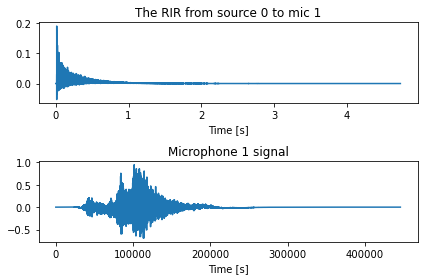

In [13]:
c_degree = 20               # Temperature of air (Celsius) 
c = 331.5 + 0.606*c_degree    # speed of Sound (at 1000 hPa)

dir_audio = 'audiofiles'
wfname = 'singing_mono_f32_44.1k'

# The desired reverberation time and dimensions of the room
rt60_tgt = 1.5  # seconds
room_dim = [10, 7.5, 3.5]  # meters

# import a mono wavfile as the source signal
# the sampling frequency should match that of the room
fname = pyOssWavfile.str_fname(dir_audio, wfname)
fmt_chunk, audio, st_fmt, t = pyOssWavfile.readf32(fname)
fs = st_fmt.fs

# We invert Sabine's formula to obtain the parameters for the ISM simulator
e_absorption, max_order = pyroom.inverse_sabine(rt60_tgt, room_dim, c=c)
print(e_absorption, max_order)


# Create the room
rooms = pyroom.ShoeBox(
    room_dim, fs=fs, materials=pyroom.Material(e_absorption), max_order=max_order
    )

print(rooms)

# place the source in the room
rooms.add_source([2.5, 3.73, 1.76], signal=audio, delay=0.5)

# define the locations of the microphones
mic_locs = np.c_[
    [6.3, 4.87, 1.2], [6.3, 4.93, 1.2],  # mic 1  # mic 2
]

# finally place the array in the room
rooms.add_microphone_array(mic_locs)

# Run the simulation (this will also build the RIR automatically)
rooms.simulate()

fnamesave = pyOssWavfile.str_fname(dir_audio,wfname+'_reverb_1.5s')
rooms.mic_array.to_wav( fnamesave, mono=True, norm=True, bitdepth=np.float32,)

# measure the reverberation time
rt60 = rooms.measure_rt60(plot=True)
print("The desired RT60 was {}".format(rt60_tgt))
print("The measured RT60 is {}".format(rt60[1, 0]))
print("The measured RT60 is {}".format(rt60[0, 0]))

# Create a plot
plt.figure()

# plot one of the RIR. both can also be plotted using room.plot_rir()
rir_1_0 = rooms.rir[1][0]
plt.subplot(2, 1, 1)
plt.plot(np.arange(len(rir_1_0)) / rooms.fs, rir_1_0)
plt.title("The RIR from source 0 to mic 1")
plt.xlabel("Time [s]")

# plot signal at microphone 1
plt.subplot(2, 1, 2)
plt.plot(rooms.mic_array.signals[1, :])
plt.title("Microphone 1 signal")
plt.xlabel("Time [s]")

plt.tight_layout()
plt.show()


float64
float64


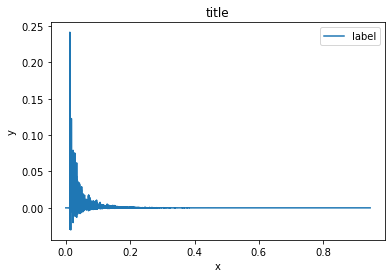

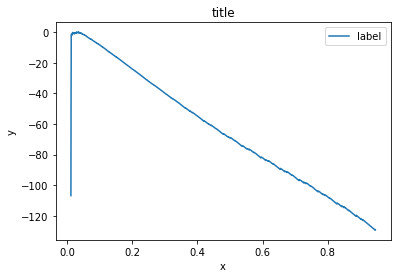

(array([[0.389]]), array([[0.3]]))


In [12]:
imp_gen_data_0_0 = rooms.rir[0][0]
print (imp_gen_data_0_0.dtype)
imp_gen_data_1_0 = rir_1_0
print (imp_gen_data_0_0.dtype)

dbg.dPlotAudio(rooms.fs, imp_gen_data_0_0)
d_curve = room.decayCurve(imp_gen_data_0_0, imp_gen_data_0_0.shape[0]/rooms.fs, rooms.fs)
dbg.dPlotAudio(rooms.fs, d_curve)
print(room.RT60(d_curve,rooms.fs))

#pyOssWavfile.write("impulse_gen_0_0.wav", rooms.fs, np.float32(imp_gen_data_0_0))
